Jupyter script to plot the figures presented in 

A dynamically-structured renewal process-based matrix population model for life histories observed under variable conditions.
Kamil Erguler, Jacob Mendel, Dusan Veljko Petric, Mina Petric, Mihaela Kavran, Murat Can Demirok, Filiz Gunay, Pantelis Georgiades, Bulent Alten, Jos Lelieveld.

 Copyright (C) 2022  Kamil Erguler
 
     This program is free software: you can redistribute it and/or modify
     it under the terms of the GNU General Public License as published by
     the Free Software Foundation, either version 3 of the License, or
     any later version.
 
     This program is distributed in the hope that it will be useful,
     but WITHOUT ANY WARRANTY; without even the implied warranty of
     MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
     GNU General Public License for more details (<https://www.gnu.org/licenses/>).

In [1]:
import numpy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta, date

import seaborn as sns
sns.set(style="ticks", color_codes=True)

from scipy.stats import gamma
from scipy.stats import nbinom
from scipy.stats import poisson
from scipy.stats import erlang
from scipy.stats import norm as gaussian

from numpy.random import uniform
from numpy.random import normal
from numpy.random import poisson as rpois
from numpy.random import binomial, choice
from numpy.random import geometric

from scipy.interpolate import interp1d
from scipy.special import gamma as fgamma
from scipy.special import gammaincc
from scipy.special import gammainccinv
from scipy.special import factorial

from scipy.integrate import odeint

# This is the Python wrapper for the sPop2 library available from https://github.com/kerguler/sPop2
from spop2 import spop
from spop2 import approximate

import pandas
import run_noise

import model
import modelsim
import culex
import vtemp
import priorP

prange = [5,50,95]

Setting up RNG GSL_RNG for Python


Env. data check: True
Quantized: True


# Figure 1
Note: StagePop package of R was used to perform the DDE simulations. The code is provided in *run_DDE.R*. The output is transferred via the *mat/solveDDE_out.csv* file.

In [4]:
xr = numpy.arange(0,50,0.01)
xri = numpy.arange(0,200,1)
mu = numpy.array([40.0,20.0])
sd = numpy.array([5.0,5.0])
theta = sd * sd / mu
k = mu / theta

dde = pandas.read_csv("mat/solveDDE_out.csv")

def solveLCT(xr, mean, stdev):
    theta = stdev * stdev / mean
    N = int(numpy.abs(mean / theta))
    init = [0.0 if n else 100.0 for n in range(N+1)]
    def f(y,n,pr):
        if n==0:
            return -pr * y[0]
        elif n<N:
            return pr * (y[n-1] - y[n])
        else:
            return pr * y[n-1]
    def odeLCT(y, t):
        gam = 1.0 / theta
        dydt = [f(y, n, gam) for n in range(N+1)]
        return dydt
    return odeint(odeLCT, init, xr)
solLCT40 = solveLCT(xr, 40.0, 5.0)
solLCT20 = solveLCT(xr, 20.0, 5.0)

def ode(y, t):
    lam = 1.0 / 20.0 if t > 20.0 else 1.0 / 40.0
    dydt = [-lam * y[0]]
    return dydt
sol = odeint(ode, 100, xr)

def solveAge(mu, sd):
    a = spop(stochastic=False,gamma_fun="MODE_GAMMA_HASH")
    a.add(0,0,0,0,100)
    ret = [[0]+a.read()]
    for n in xri[1:]:
        i = 0 if n<=20 else 1
        a.iterate(0,mu[i],sd[i],0,0,0)
        ret.append([n]+a.read())
    ret = numpy.array(ret)
    return ret
retH = solveAge(mu, sd)
retH20 = solveAge([20, 20], [5, 5])
retH40 = solveAge([40, 40], [5, 5])

a = spop(stochastic=False,gamma_fun="MODE_ACCP_ERLANG")
a.add(0,0,0,0,100)
retA = [[0]+a.read()]
retL = [a.retrieve()]
for n in xri[1:]:
    i = 0 if n<=20 else 1
    a.iterate(0,mu[i],sd[i],0,0,0)
    retA.append([n]+a.read())
    retL.append(a.retrieve())
retA = numpy.array(retA)
retL = numpy.array(retL)

/Users/kamil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


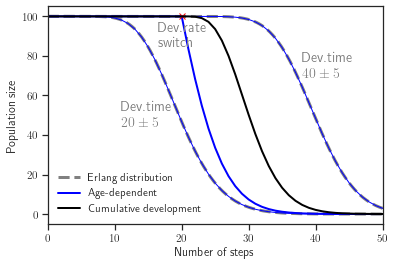

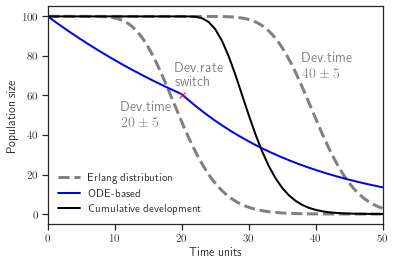

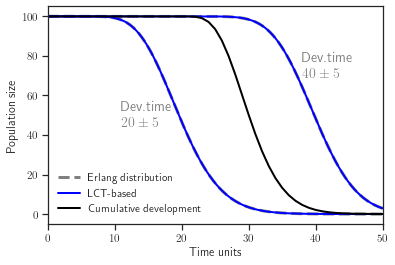

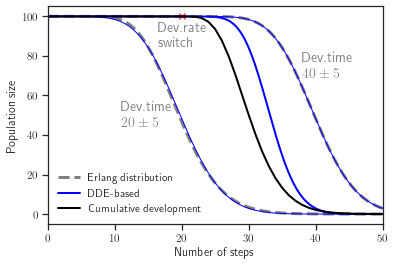

In [5]:

for mode in range(4):
    for i in numpy.arange(len(mu))[::-1]:
        plt.plot(xr,100*(1.0-erlang.cdf(xr,k[i],0,theta[i])), c="gray", lw=3, ls="dashed", label=None if i else "Erlang distribution")
    #
    if mode==0:
        plt.plot(xri,retH[:,1], c="blue", lw=2, label="Age-dependent")
        plt.plot(xri,retH20[:,1], c="blue", lw=1)
        plt.plot(xri,retH40[:,1], c="blue", lw=1)
        plt.text(16.5,85,"Dev.rate\nswitch",c="gray",weight="bold")
        plt.plot(20,100, 'x', c="red")
        plt.xlabel("Number of steps")
    elif mode==1:
        plt.plot(xr,sol[:,0],c="blue",lw=2,label="ODE-based")
        plt.text(19,65,"Dev.rate\nswitch",c="gray",weight="bold")
        plt.plot(20,60, 'x', c="red")
        plt.xlabel("Time units")
    elif mode==2:
        plt.plot(xr,100.0-solLCT40[:,-1],c="blue",lw=2,label="LCT-based")
        plt.plot(xr,100.0-solLCT20[:,-1],c="blue",lw=2)
        plt.xlabel("Time units")
    elif mode==3:
        plt.plot(dde['time'], 100*dde['sizeS'], c="blue", lw=1)
        plt.plot(dde['time'], 100*dde['sizeM'], c="blue", lw=2, label="DDE-based")
        plt.plot(dde['time'], 100*dde['sizeL'], c="blue", lw=1)
        plt.text(16.5,85,"Dev.rate\nswitch",c="gray",weight="bold")
        plt.plot(20,100, 'x', c="red")
        plt.xlabel("Number of steps")
    #
    plt.plot(xri,retA[:,1], c="black", lw=2, label="Cumulative development")
    plt.text(11,45,"Dev.time\n$20\pm5$",c="gray",weight="bold")
    plt.text(38,70,"Dev.time\n$40\pm5$",c="gray",weight="bold")
    plt.ylim(-5,105)
    plt.xlim(0,50)
    plt.legend(frameon=False)
    plt.ylabel("Population size")
    plt.savefig("figures/Figure1a_%d.pdf" %mode,bbox_inches="tight",dpi=300)
    plt.show()
    plt.close()

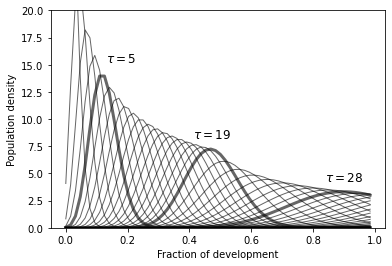

In [9]:

for i in range(len(retL)):
    r = retL[i]
    s = numpy.argsort(r[0])
    plt.plot(r[0][s],r[1][s],c="black",alpha=0.6,lw=3 if i in [5, 19, 28] else 1)
plt.text(0.13,15,r"$\tau=5$",horizontalalignment='left',verticalalignment='bottom',fontsize=12)
plt.text(0.475,8,r"$\tau=19$",horizontalalignment='center',verticalalignment='bottom',fontsize=12)
plt.text(0.9,4,r"$\tau=28$",horizontalalignment='center',verticalalignment='bottom',fontsize=12)
plt.ylim(0,20)
plt.ylabel("Population density")
plt.xlabel("Fraction of development")
plt.savefig("figures/FigureS1.pdf",bbox_inches="tight",dpi=300)
plt.show()

# Figure 2
Note: Due to the extended simulation time, the **run_noise.py** was used to generate the data plotted in this section.

In [7]:
import run_noise

temp = [15,25,35]
labels = [r"$\rho_L$",r"$\rho_M$",r"$\rho_H$"]
clscl = ["#2b83ba","#abdda4","#fdae61"]

def briere1(T,T1,T2,a):
    return a*T*(T-T1)*numpy.sqrt(T2-T)

xr = numpy.arange(0,50.001,0.01)
yr = briere1(xr,0,50,1.5e-5)

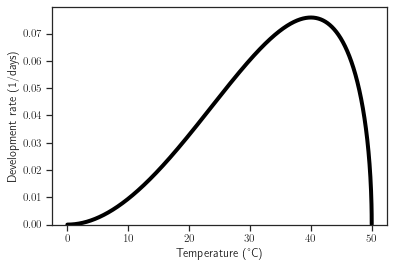

/Users/kamil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/Users/kamil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


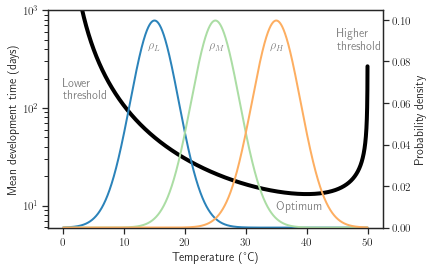

In [100]:
fig, ax = plt.subplots()
ax.plot(xr,yr, color="black", lw=4)
ax.set_ylim(bottom=0)
ax.set_ylabel("Development rate (1/days)")
ax.set_xlabel("Temperature (°C)")
plt.savefig("figures/Figure2a.pdf",bbox_inches="tight",dpi=300)
plt.show()

fig, ax = plt.subplots()
ax1 = ax.twinx()
ax.plot(xr,1/yr, color="black", lw=4)
for i in range(len(temp)):
    ax1.plot(xr,gaussian.pdf(xr,temp[i],4), color=clscl[i], lw=2)
ax1.set_ylim(bottom=0)
ax1.set_ylabel("Probability density")
ax.set_yscale("log")
ax.set_ylabel("Mean development time (days)")
ax.set_xlabel("Temperature (°C)")
ax.text(0,125,"Lower\nthreshold",c="gray",weight="bold")
ax.text(45,400,"Higher\nthreshold",c="gray",weight="bold")
ax.text(35,9,"Optimum",c="gray",weight="bold")
for i in range(len(labels)):
    ax.text(temp[i]-1,400,labels[i],c="gray",weight="bold")
ax.set_ylim(0,1e3)
plt.savefig("figures/Figure2b.pdf",bbox_inches="tight",dpi=300)
plt.show()

out_D = [numpy.array(run_noise.sim(m, 0)) for m in temp]
out_S = [run_noise.summarize(numpy.load("mat/run_noise_mu%g_sd4_n1000_e0.0001.npy" %m)) for m in temp]

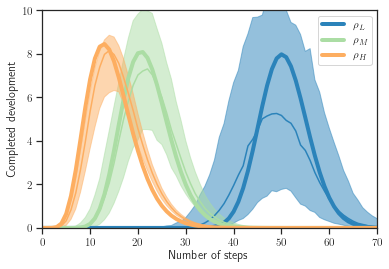

In [85]:
for i in range(len(temp)):
    out = out_D[i]
    plt.plot(out[:,0], out[:,3], label=labels[i], color=clscl[i], lw=4)
    out = out_S[i]
    plt.fill_between(out['median']['step'], out['lower']['developed'], out['higher']['developed'], color=clscl[i], alpha=0.5)
    plt.plot(out['median']['step'], out['median']['developed'], color=clscl[i])
plt.xlabel("Number of steps")
plt.ylabel("Completed development")
plt.ylim(0,10)
plt.xlim(0,70)
plt.legend()
plt.savefig("figures/Figure2c.pdf",bbox_inches="tight",dpi=300)
plt.show()

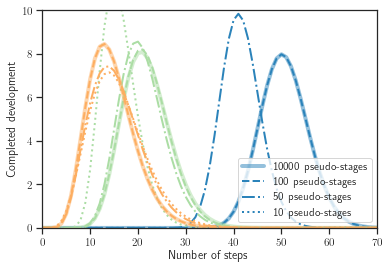

In [12]:
out_D1 = [numpy.array(run_noise.sim(m, 0, 0.0001)) for m in temp]
out_D2 = [numpy.array(run_noise.sim(m, 0, 0.01)) for m in temp]
out_D3 = [numpy.array(run_noise.sim(m, 0, 0.02)) for m in temp]
out_D4 = [numpy.array(run_noise.sim(m, 0, 0.1)) for m in temp]

for i in range(len(temp)):
    plt.plot(out_D1[i][:,0], out_D1[i][:,3], color=clscl[i], lw=4, label="10000 pseudo-stages" if i==0 else None, alpha=0.5)
    plt.plot(out_D2[i][:,0], out_D2[i][:,3], color=clscl[i], lw=2, ls='dashed', label="100 pseudo-stages" if i==0 else None)
    plt.plot(out_D3[i][:,0], out_D3[i][:,3], color=clscl[i], lw=2, ls='dashdot', label="50 pseudo-stages" if i==0 else None)
    plt.plot(out_D4[i][:,0], out_D4[i][:,3], color=clscl[i], lw=2, ls='dotted', label="10 pseudo-stages" if i==0 else None)
plt.legend(loc="lower right")
plt.xlabel("Number of steps")
plt.ylabel("Completed development")
plt.ylim(0,10)
plt.xlim(0,70)
plt.savefig("figures/FigureS2.pdf",bbox_inches="tight",dpi=300)
plt.show()

# Figure 3

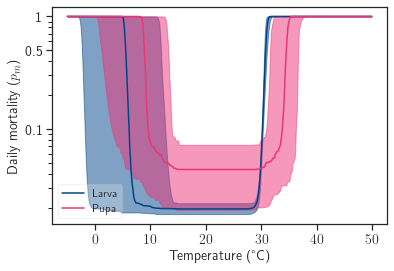

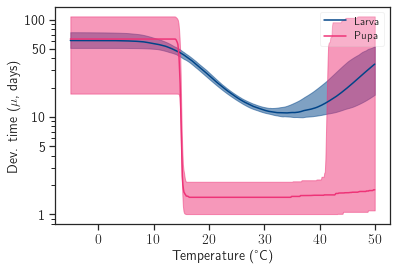

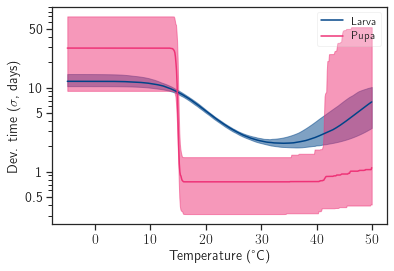

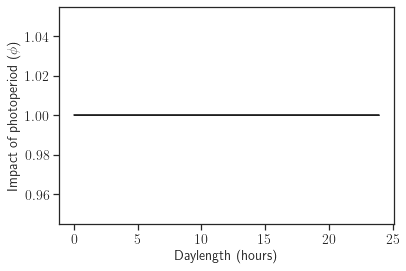

In [2]:
paramQ = modelsim.paramQ.copy()
model.plotPDC(paramQ, ylog=True, subset=True, filename="figures/param_Cxquin_C", filetype='pdf')

# Figure 3 (additional)

In [4]:
obs = [
            culex.obs['15-1'],
            culex.obs['15-2'],
            culex.obs['15-3'],
            culex.obs['20-1'],
            culex.obs['20-2'],
            culex.obs['20-3'],
            culex.obs['23-1'],
            culex.obs['23-2'],
            culex.obs['23-3'],
            culex.obs['27-1'],
            culex.obs['27-2'],
            culex.obs['27-3'],
            culex.obs['30-1'],
            culex.obs['30-2'],
            culex.obs['30-3']
        ]
allgroups = [[0,1,2],[3,4,5],[6,7,8],[9,10,11],[12,13,14]]
paramQ = modelsim.paramQ.copy()

def middle(x,y,ym):
    tmp = numpy.where(y>ym)[0][0]
    return x[tmp-1]+(x[tmp]-x[tmp-1])*(ym-y[tmp-1])/(y[tmp]-y[tmp-1])

midobs = []
maxobs = []
midsim = []
maxsim = []
for g in range(len(allgroups)):
    grp = allgroups[g]
    midobs.append([])
    maxobs.append([])
    midsim.append([])
    maxsim.append([])
    for o in grp:
        mP = numpy.max(obs[o]['P'])
        mA = numpy.max(obs[o]['A'])
        maxobs[g].append([mP,mA])
        midobs[g].append([middle(obs[o]['days'],obs[o]['P'],0.5*mP), middle(obs[o]['days'],obs[o]['A'],0.5*mA)])
        tm = numpy.arange(obs[o]['days'][-1]*model.TSCALE+1)/model.TSCALE
        for pr in paramQ:
            sm, ss = model.matchSim(obs[o],pr)
            mP = numpy.max(ss[:,2])
            mA = numpy.max(ss[:,3])
            maxsim[g].append([mP, mA])
            midsim[g].append([middle(tm,ss[:,2],0.5*mP), middle(tm,ss[:,3],0.5*mA)])
midobs = numpy.array(midobs)
maxobs = numpy.array(maxobs)
midsim = numpy.array(midsim)
maxsim = numpy.array(maxsim)


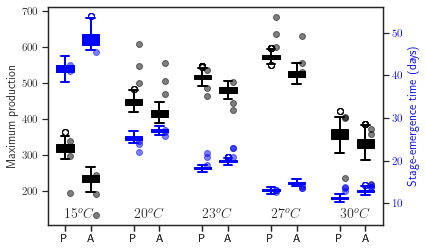

In [5]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

c = "black"
lp = numpy.repeat('P',maxsim.shape[0])
la = numpy.repeat('A',maxsim.shape[0])
ax1.boxplot(maxsim[:,:,0].T,positions=numpy.arange(maxsim.shape[0])*2,labels=lp,patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c,linewidth=2),
            whiskerprops=dict(color=c,linewidth=2),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c))
ax1.boxplot(maxsim[:,:,1].T,positions=numpy.arange(maxsim.shape[0])*2+0.75,labels=la,patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c,linewidth=2),
            whiskerprops=dict(color=c,linewidth=2),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c))
c = "blue"
ax2.boxplot(midsim[:,:,0].T,positions=numpy.arange(midsim.shape[0])*2,labels=lp,patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c,linewidth=2),
            whiskerprops=dict(color=c,linewidth=2),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c))
ax2.boxplot(midsim[:,:,1].T,positions=numpy.arange(midsim.shape[0])*2+0.75,labels=la,patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c,linewidth=2),
            whiskerprops=dict(color=c,linewidth=2),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c))
for g in range(midobs.shape[0]):
    ax1.plot(numpy.repeat(g*2+0.15,maxobs.shape[1]),maxobs[g,:,0],'o',color="black",alpha=0.5)
    ax1.plot(numpy.repeat(g*2+0.9,maxobs.shape[1]),maxobs[g,:,1],'o',color="black",alpha=0.5)
    ax2.plot(numpy.repeat(g*2+0.15,midobs.shape[1]),midobs[g,:,0],'o',color="blue",alpha=0.5)
    ax2.plot(numpy.repeat(g*2+0.9,midobs.shape[1]),midobs[g,:,1],'o',color="blue",alpha=0.5)
    ax2.text(g*2,6.5,r"$%d^{o}C$" %(numpy.array([15,20,23,27,30])[g]))
ax2.set_ylim(bottom=5)
ax1.set_ylabel("Maximum production")
ax2.set_ylabel("Stage-emergence time (days)")
ax2.yaxis.label.set_color('blue')
[t.set_color('blue') for t in ax2.yaxis.get_ticklines()]
[t.set_color('blue') for t in ax2.yaxis.get_ticklabels()]
plt.savefig("figures/Figure4a.pdf",bbox_inches="tight",dpi=300)
plt.show()

# Figure 4

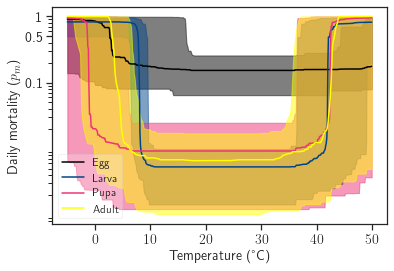

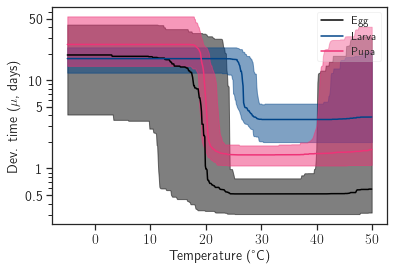

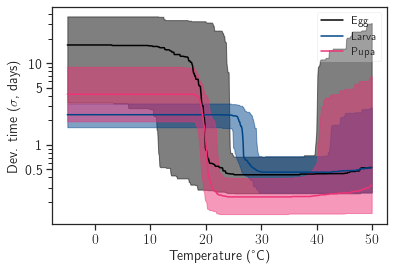

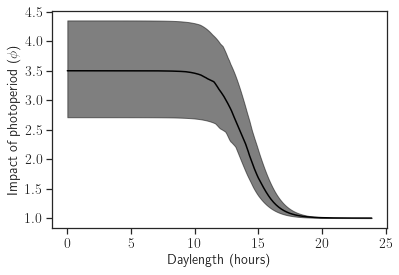

In [3]:
paramP = modelsim.paramP.copy()
model.plotPDC(paramP, ylog=True, filename="figures/param_Cxpip_C", filetype='pdf')

# Average critical photoperiod

In [27]:
ph = numpy.arange(0,24,0.1)
xr = numpy.repeat(25.0,len(ph))
pp = numpy.array([model.getPD(xr,ph,model.rescalepar(pr)) for pr in paramP])
numpy.mean(numpy.array([ph[numpy.where(p[:,10]<0.5*(numpy.min(p[:,10])+numpy.max(p[:,10])))[0][0]] for p in pp]))


14.146

# Figure 5

In [77]:
dd = {i:modelsim.calcObs(vtemp.obs[i]) for i in vtemp.obs}
if True:
    import pickle
    era5 = pickle.load(open("mat/clim_Petrovaradin.pickle",'rb'))
    rets = numpy.array([modelsim.simClims([era5],param,thr=1e-3) for param in paramP])
    # numpy.save("mat/data_era5_paramP_2017_2018.npy",rets,allow_pickle=True)
else:
    rets = numpy.load("mat/data_era5_paramP_2017_2018.npy",allow_pickle=True)

ret = rets[:,:,1:]
tm, pp, m = modelsim.calcRet(ret)

/Users/kamil/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1396: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/Users/kamil/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1376: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


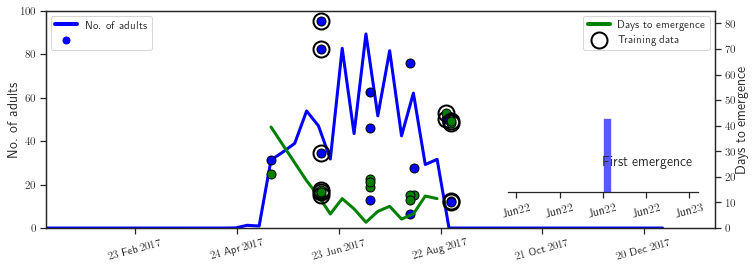

In [78]:
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [12, 4]
fig, ax = plt.subplots()
ax.fill_between(tm,pp[0][:,0],pp[2][:,0],alpha=0.35,color="blue")
ax.plot(tm,pp[1][:,0],alpha=1,lw=3,color="blue",label="No. of adults")
ax.set_ylabel("No. of adults",fontsize=14,labelpad=0)

ax1 = ax.twinx()  
ax1.fill_between(tm,pp[0][:,1],pp[2][:,1],alpha=0.35,color="green")
ax1.plot(tm,pp[1][:,1],alpha=1,lw=3,color="green",label="Days to emergence")
ax1.set_ylim(0,85)
ax1.set_ylabel("Days to emergence",fontsize=14,labelpad=0)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))
ax.xaxis.set_major_locator(plt.MaxNLocator(7))
ax.tick_params(axis='x', which='major', rotation=15)
ax.set_xlim(date(2017,1,1),date(2018,1,31))
ax.set_ylim(0,100)
#
label = False
for i in dd:
    d = dd[i]
    ax.plot(d['Date'],d['Ap'],'o',ms=9,color="black")
    ax1.plot(d['Date'],d['lA'],'o',ms=9,color="black")
    ax.plot(d['Date'],d['Ap'],'o',ms=7,color="blue", label=None if label else "% eggs emerged")
    label = True
    ax1.plot(d['Date'],d['lA'],'o',ms=7,color="green")
    if i in [4,12,13,9,10,11]: # to be tested
    # if i in [12,10]:
        ax.plot(d['Date'],d['Ap'],'o',ms=16,markeredgewidth=2,markerfacecolor='none',markeredgecolor="black")
        ax1.plot(d['Date'],d['lA'],'o',ms=16,markeredgewidth=2,markerfacecolor='none',markeredgecolor="black",label="Training data" if i==10 else None)
#
lgnd = ax.legend(loc='upper left')
for l in lgnd.legendHandles:
    l.set_linewidth(4)
    l.set_alpha(1)
lgnd = ax1.legend(loc='upper right')
for l in lgnd.legendHandles:
    l.set_linewidth(4)
    l.set_alpha(1)
#
left, bottom, width, height = [0.66, 0.25, 0.22, 0.27]
ax2 = fig.add_axes([left, bottom, width, height])
h = ax2.hist(m,bins=20,color="blue",alpha=0.65)
ax2.patch.set_alpha(0.0)
ax2.text(numpy.min(m),0.35*numpy.max(h[0]),"First emergence",fontsize=14)
ax2.yaxis.set_major_locator(plt.NullLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b%d'))
ax2.xaxis.set_major_locator(plt.MaxNLocator(5))
ax2.tick_params(axis='both', which='major', labelsize=12, rotation=15)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
#
plt.savefig("figures/global_TTE_ERA5_P_data_V2.pdf",bbox_inches="tight",dpi=300)
plt.show()

In [132]:
dt = {}
tm = {}
ph = {}
sm = {}
weeks = [20,21,22,23,24,25,26,27,28,29,30]
clscl = [model.colours[spc] for spc in ['E','L','P','A']]
for w in weeks:
    ii = w*7*modelsim.TSCALE
    ii2 = ii + 6*7*modelsim.TSCALE
    dt[w] = era5['days'][ii:ii2]
    tm[w] = numpy.array(era5['mean_air_temp'][ii:ii2].data)
    ph[w] = era5['photoperiod'][ii:ii2]
    sm[w] = numpy.array([modelsim.sim(tm[w],ph[w],pr,init=numpy.array([100.0,0,0,0]),thr=1e-3) for pr in paramP])

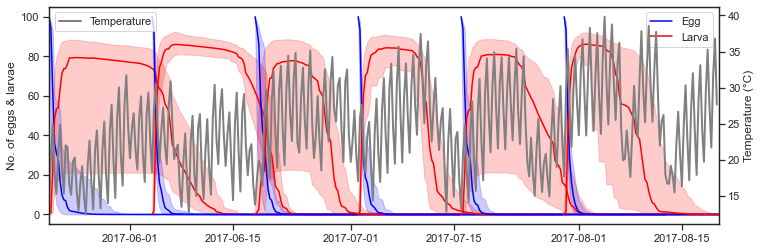

In [152]:
weeks = [20,22,24,26,28,30]
ii = 20*7*modelsim.TSCALE
ii2 = ii + 13*7*modelsim.TSCALE

plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [12, 4]
fig, ax = plt.subplots()
ax1 = ax.twinx()
ax1.plot(era5['days'][ii:ii2],numpy.array(era5['mean_air_temp'][ii:ii2].data),lw=2,c="gray",label="Temperature")
label = False
for w in weeks:
    for i in [0,1]:
        obj = sm[w][:,:,i]
        # obj = numpy.cumsum(sm[w][:,:,7],axis=1)
        pp = numpy.percentile(obj,prange,axis=0)
        ax.fill_between(dt[w],pp[0],pp[2],color=clscl[i],alpha=0.2)
        ax.plot(dt[w],pp[1],c=clscl[i],label=None if label else model.namesC[i])
    label = True
ax1.set_ylabel("Temperature (°C)")
ax.set_ylabel("No. of eggs & larvae")
ax1.legend()
ax.legend()
plt.xlim(era5['days'][ii],era5['days'][ii2])
plt.savefig("figures/global_TTE_ERA5_P_data_V2_variation.pdf",bbox_inches="tight",dpi=300)
plt.show()

# Figure SN1

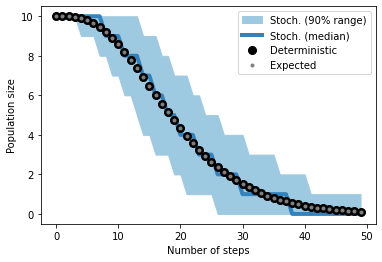

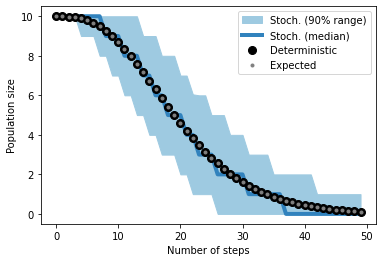

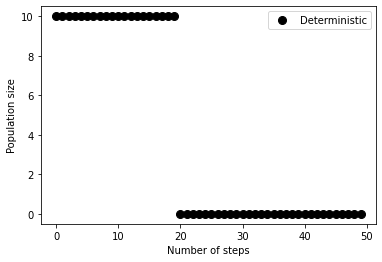

In [ ]:
N = 10.0
mu = 20.0
sd = 10.0

def simDet(mode):
    a = spop(stochastic=False,gamma_fun=mode)
    a.add(0,0,0,0,N)
    retd = [[0]+a.read()]
    for n in numpy.arange(1,50):
        a.iterate(0,mu,sd,0,0,0)
        retd.append([n]+a.read())
    return numpy.array(retd)

def simStoch(mode):
    rets = []
    for r in range(1000):
        a = spop(stochastic=True,gamma_fun=mode)
        a.add(0,0,0,0,N)
        tmp = [[0]+a.read()]
        for n in numpy.arange(1,50):
            a.iterate(0,mu,sd,0,0,0)
            tmp.append([n]+a.read())
        rets.append(tmp)
    rets = numpy.array(rets)
    return numpy.percentile(rets,prange,axis=0)

modes = {
    'erlang':{'mode':'MODE_ACCP_ERLANG','figure':'1a'},
    'pascal':{'mode':'MODE_ACCP_PASCAL','figure':'1b'},
    'fixed':{'mode':'MODE_ACCP_FIXED','figure':'1c'}
}

for key in modes:
    if key=='pascal':
        theta = mu / (sd * sd)
        k = mu * theta / (1.0 - theta)
    elif key=='erlang':
        theta = sd * sd / mu
        k = mu / theta
    elif key=='fixed':
        theta = 1
        k = mu
    #
    retd = simDet(modes[key]['mode'])
    if not (key=='fixed'):
        retp = simStoch(modes[key]['mode'])
    #
    xr = numpy.arange(0,50,1)
    handles = []
    if not (key=='fixed'):
        handles.append(plt.fill_between(retp[1][:,0],retp[0][:,1],retp[2][:,1],color="#9ecae1",label="Stoch. (90% range)"))
        handles.append(plt.plot(retp[1][:,0],retp[1][:,1],c="#3182bd",label="Stoch. (median)",lw=4)[0])
    handles.append(plt.plot(retd[:,0],retd[:,1],'o',c="black",label="Deterministic",markersize=8)[0])
    if key=='pascal':
        handles.append(plt.plot(xr,N*(1.0-nbinom.cdf(xr-1,k,theta)),'.',c="gray",label="Expected",markersize=6)[0])
        # Note:
        # The probability of accumulating $k$ successes in $\tau$ time steps is equal to 
        # the probability of $1$ failure before $k$ successes, where the second failure is a given. 
        # Therefore, the cumulative density function corresponds to $F(\tau-1,k,\theta)$.
    elif key=='erlang':
        handles.append(plt.plot(xr,N*(1.0-erlang.cdf(xr,k,0,theta)),'.',c="gray",label="Expected",markersize=6)[0])
    plt.legend(handles,[handle.get_label() for handle in handles],loc="upper right")
    plt.ylabel("Population size")
    plt.xlabel("Number of steps")
    plt.savefig("figures/FigureSN1_%s.pdf" %(modes[key]['figure']),bbox_inches="tight",dpi=300)
    plt.show()

# Figure S2

In [2]:
obs = [
            culex.obs['15-1'],
            culex.obs['15-2'],
            culex.obs['15-3'],
            culex.obs['20-1'],
            culex.obs['20-2'],
            culex.obs['20-3'],
            culex.obs['23-1'],
            culex.obs['23-2'],
            culex.obs['23-3'],
            culex.obs['27-1'],
            culex.obs['27-2'],
            culex.obs['27-3'],
            culex.obs['30-1'],
            culex.obs['30-2'],
            culex.obs['30-3']
        ]
testgroups = [[1,2],[4,5],[7,8],[10,11],[13,14]]
allgroups = [[0,1,2],[3,4,5],[6,7,8],[9,10,11],[12,13,14]]
traingroups = [0,3,6,9,12]
paramQ = modelsim.paramQ.copy()

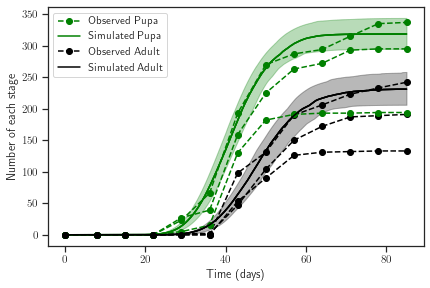

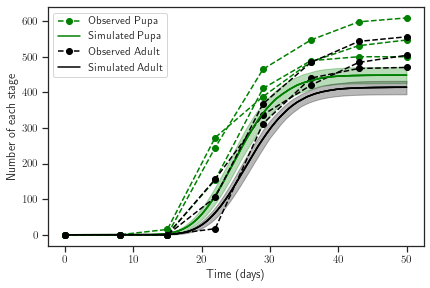

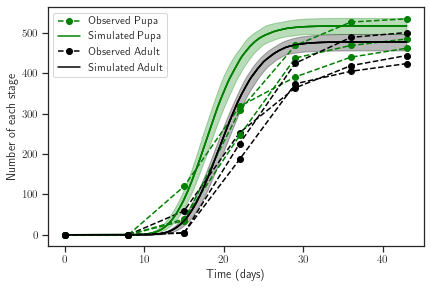

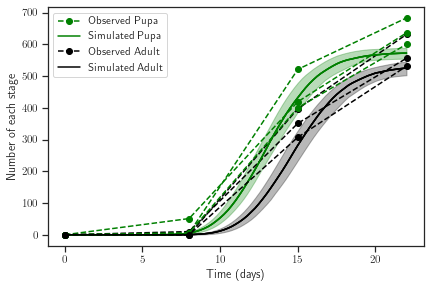

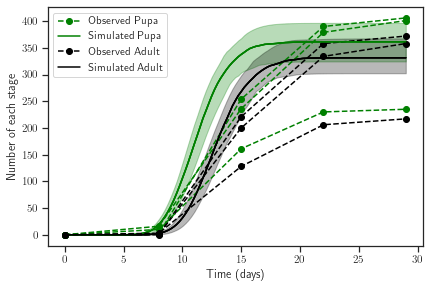

In [3]:
for grp in allgroups:
    model.plotMatches([obs[g] for g in grp],paramQ,dates=False,legend=True,filename="figures/ttest_Cxquin_"+"_".join([str(g) for g in grp]),filetype="pdf")

# Figure S3

In [2]:
obs = [
            vtemp.obs[1],  #   0   g
            vtemp.obs[2],  #   1   g
            vtemp.obs[3],  #   2   e
            vtemp.obs[4],  #   3   c
            vtemp.obs[5],  #   4   a
            vtemp.obs[6],  #   5   a
            vtemp.obs[7],  #   6   b
            vtemp.obs[8],  #   7   f
            vtemp.obs[9],  #   8   i
            vtemp.obs[10], #   9   h
            vtemp.obs[11], #   10  j
            vtemp.obs[12], #   11  d
            vtemp.obs[13], #   12  c
            vtemp.obs[14], #   13  f
            vtemp.obs[15], #   14  f
            vtemp.obs[16]  #   15  g
        ]
testgroups = [[0,1,15],[2],[3,12],[4,5],[6],[7,13,14],[8],[10]]
testobs = [5,6,7,4,13,12,3,8,14,15,2,16,1,9,10,11] # (vtemp.obs[g])
allgroups = [[0,1,15],[2],[3,12],[4,5],[6],[7,13,14],[8],[10],[11],[9]]
traingroups = [11,9] # in manuscript
traingroups = [3,11,12,8,9,10] # to test
trainobs = [4,12,13,9,10,11] # to test (vtemp.obs[g])
paramP = modelsim.paramP.copy()

In [ ]:
for grp in allgroups:
    model.plotMatches([obs[g] for g in grp],[],dates=True,legend=True,envir=True,filename="figures/data_Cxpip_"+"_".join([str(g) for g in grp]),filetype="pdf")

In [73]:
paramP = numpy.array([[13.46840828812251,51.20672728825176,0.0528700641731113,0.6087875280912974,0.8091175148478116,10.4046171650919,53.79500030598042,0.0005563820803747549,0.3083330377263906,0.1521070258814829,0.3820457432872706,35.09614152946472,0.0004486086428168552,0.1200866658731397,0.2584084881736338,3.531686055402473,46.2412059861792,0.0001846429139760045,0.6344017539241273,0.569812684397198,25.3088953902216,24.63726473198864,-6.122782154370496,0.3080508406714672,26.06533159425965,45.95138044221456,-7.124992402202308,0.1411690097810845,18.41715144578232,15.55128874644575,-7.925390705149894,0.1237672408695161,17.23761827924009,7.464452998879103]])
paramP = numpy.array([[3.743472386758054,42.57823465059803,0.02441674425043832,0.2367662680955207,0.1767616353645325,9.199522588753918,26.23623071113126,0.0003681689344129267,0.2259362489471141,0.3024849369075728,1.919932276172114,44.34814922375169,0.0001108311300561648,0.2369831295572824,0.809683209690073,3.498258219898208,52.22613125235322,3.185047677249417e-05,0.2698799651117402,0.237938313790539,7.278717962688298,14.61135238423075,-5.578421365718824,0.5982386637440921,15.43568360919045,8.600228688192447,-7.274399502800042,0.129515899937516,17.20775516193476,12.00709642359433,-7.37292879165913,0.1452583246839542,13.83974863962238,8.275017432754542]])
paramP = numpy.array([[14.29354412008191,54.05124174584517,0.03597678667695934,0.2877292684556931,0.5467065572024359,10.52788949214355,33.59479760814891,4.651840794029901e-05,0.2436583272081442,0.9402206686472542,1.179327355484684,29.40304918950757,0.0007278703776595906,0.07020759428092233,0.4156748444424626,-3.65344445700659,48.30690272840747,0.0002599787976633235,0.7458030372123774,0.3012618931213032,27.33363367089635,21.37744920163247,-5.282095039550068,0.944896031555149,23.51825357630022,32.55077652372526,-7.712339743429962,0.1271837599115097,19.28607133545979,10.14872712660721,-7.099436903519025,0.1010683600898597,17.29432602938748,6.15918795543419]])
paramP = numpy.array([[15.10304485276009,43.83618919263067,0.02470628844617477,0.3358077085479914,0.6863387257607787,9.366133933818507,26.23623071113126,0.0003681689344129267,0.259313543872815,0.1938363752930331,2.532954566443842,33.87174684587583,9.321133346772701e-05,0.332761253678591,0.5143570872465083,6.794049427005795,47.07702564198581,5.953276138723235e-05,0.4050989387625502,0.3823957318383013,6.569366868424614,12.74059628022612,-4.741420794655458,0.6090396798091989,14.97753282097748,8.756786910415249,-7.312594327038196,0.1114938619037011,17.8063384114503,12.44120595144806,-7.140427411378979,0.1062249767206082,13.88620467119264,8.266431033391711]])
paramP = numpy.array([[18.3624146054803,36.350770423803,0.07953471843665703,0.3106346448409104,0.172061429810534,10.09234793225217,33.77494473504051,0.003881907288065261,0.1630097240612993,0.9667265217884676,-8.32363844439101,54.72035953422511,0.002100682890696569,0.09562733041386295,0.9787882530445202,-6.177167470742988,53.86087008432997,0.00317826083309809,0.5802233529695813,0.8822411381335813,17.75028491420283,6.059331851892327,-5.200582924139967,0.7889424642731707,28.25097950928364,33.00170919593599,-10.23267935696714,0.1425891453489272,32.99758550657349,16.88493594826818,-3.5847690173989,0.2975072193186704,11.51406093870315,8.597234892741056]])

In [3]:
paramP = numpy.array([[
    6.33885, 51.0814, 0.0532647, 0.539951, 0.347351,
     7.46733, 32.7974, 0.000668613, 0.25549, 0.710961,
     -2.85806, 39.954, 0.00256041, 0.30124, 0.715575,
     6.03093, 33.0922, 0.00465134, 0.971205, 0.240576,
     16.9202, 42.8276, 1.27288, 0.985137, # d1ms
     28.974, 25.9432, 11.4956, 0.14098, # d2ms
     19.8079, 23.1448, 5.25644, 0.16006, # d3ms
     14.1196, 3.31005
]])

In [15]:
paramP = numpy.array([
    [6.33885, 51.0814, 0.0532647, 0.539951, 0.347351,
     7.46733, 32.7974, 0.000668613, 0.25549, 0.710961,
     -2.85806, 39.954, 0.00256041, 0.30124, 0.715575,
     6.03093, 33.0922, 0.00465134, 0.971205, 0.240576,
     16.9202, 42.8276, -9, 0.985137, # d1ms
     28.974, 25.9432, -9, 0.14098, # d2ms
     19.8079, 23.1448, -9, 0.16006, # d3ms
     14.1196, 3.31005]
])

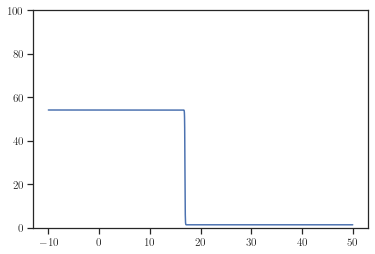

[-0.00250857 -0.00250958 -0.0025106  ...  0.00444446  0.00444525
  0.00444605]


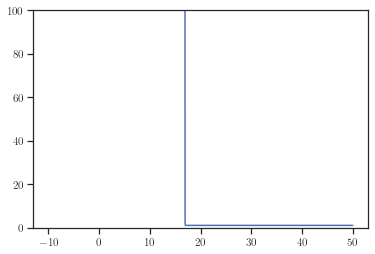

In [8]:
def fundev2(T,T0,T1,M0,M1,Ts):
    return ((M0)+(M1)/(1.0+numpy.exp((Ts)*((T0)+(T1)-(T))*((T)-(T0)))))
def briere1C(T,T0,T1,a):
    t = numpy.array([1.0/(numpy.exp(a)*(t)*((t)-(T0))*numpy.sqrt((T0)+(T1)-(t))) for t in T])
    print(t)
    t[(T)<=(T0)] = 1e13
    t[(T)>=((T0)+(T1))] = 1e13
    t[t>1e13] = 1e13
    t[t<1.0] = 1.0
    return t
def briere1(T,T0,T1,a):
    return briere1C(273.15+(T),273.15+(T0),(T1),(a))

T = numpy.arange(-10,50,0.01)
plt.plot(T, fundev2(T, 16.9202, 42.8276, 1.27288, 52.792, 0.789529))
plt.ylim(0,100)
plt.show()
plt.plot(T, briere1(T, 16.9202, 42.8276, -5))
plt.ylim(0,100)
plt.show()

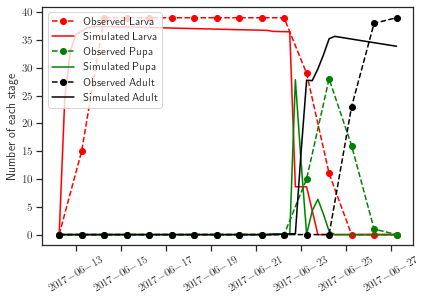

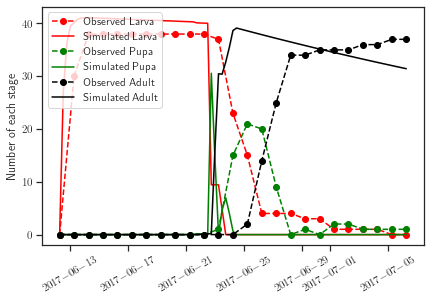

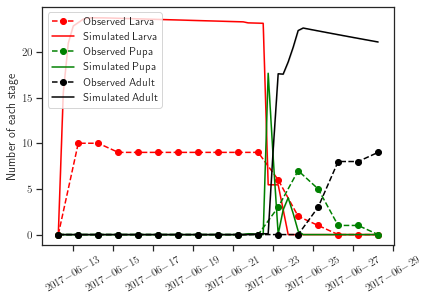

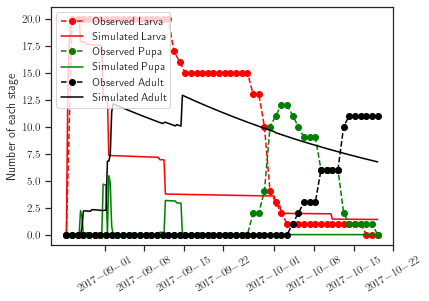

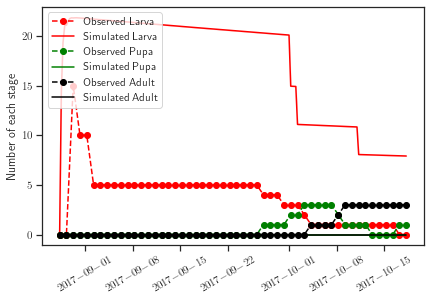

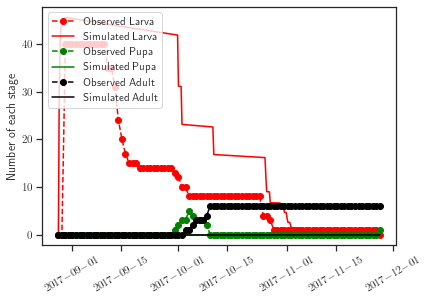

In [16]:
for grp in traingroups:
    model.plotMatches([obs[grp]],paramP,dates=True,legend=True,envir=False,filename="figures/train_Cxpip_"+str(grp),filetype="pdf")

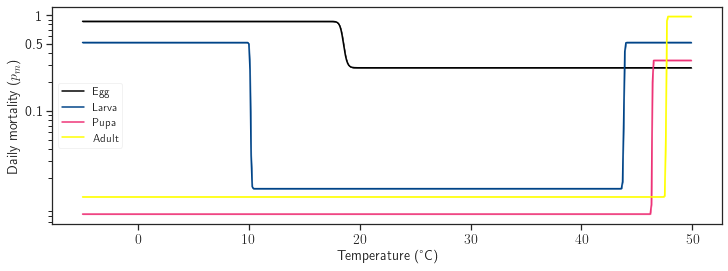

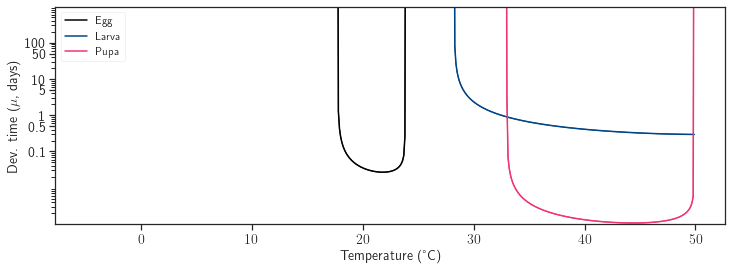

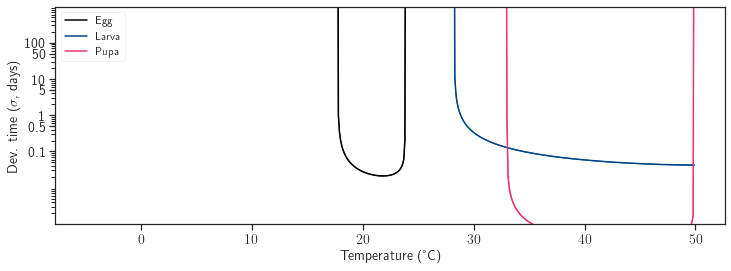

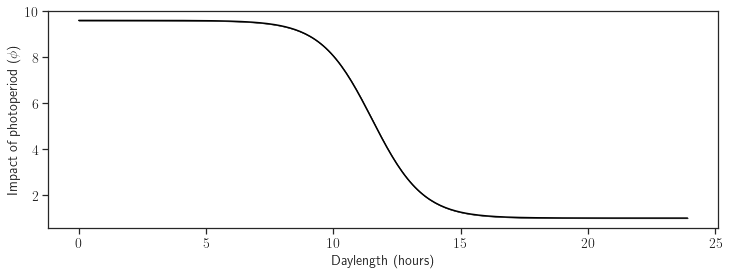

In [75]:
model.plotPDC(paramP, ylog=True, filename="figures/param_Cxpip_C", filetype='pdf', ylim=[0.001,1000])

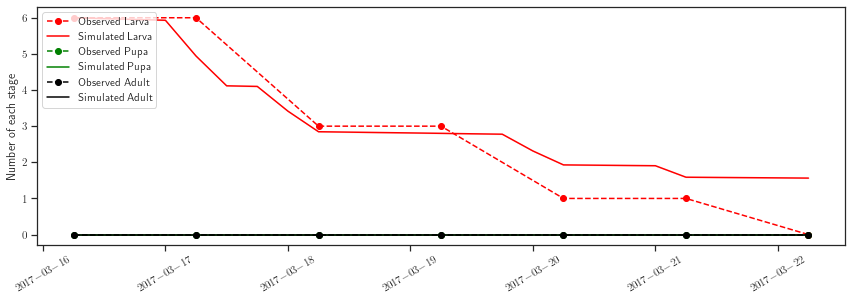

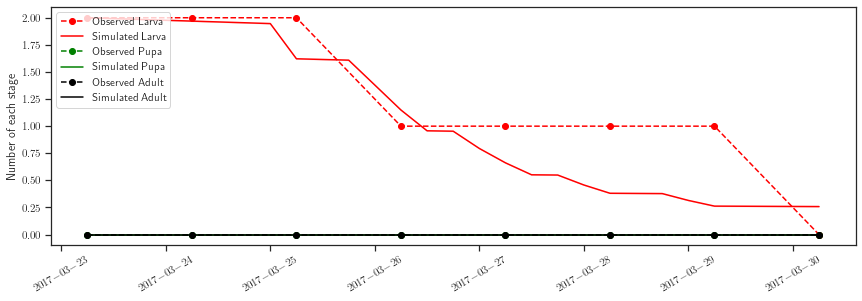

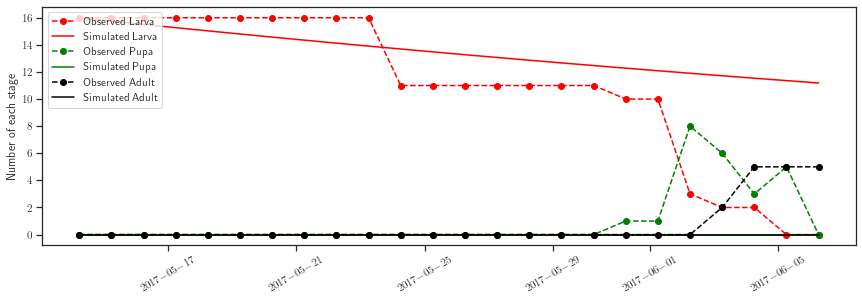

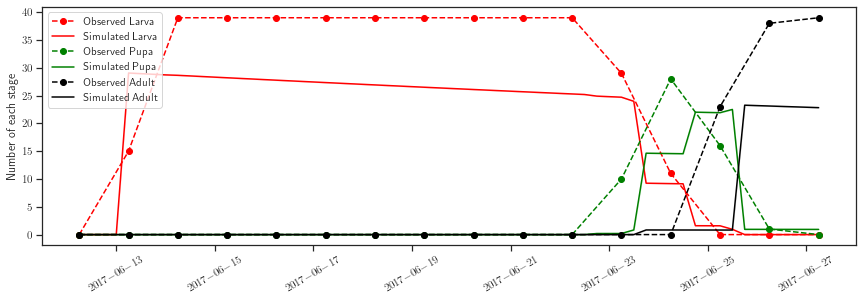

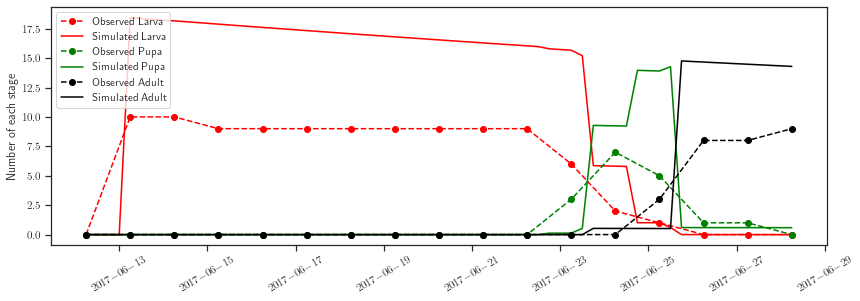

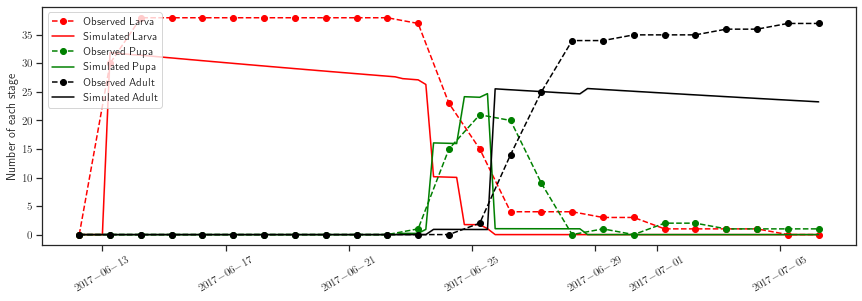

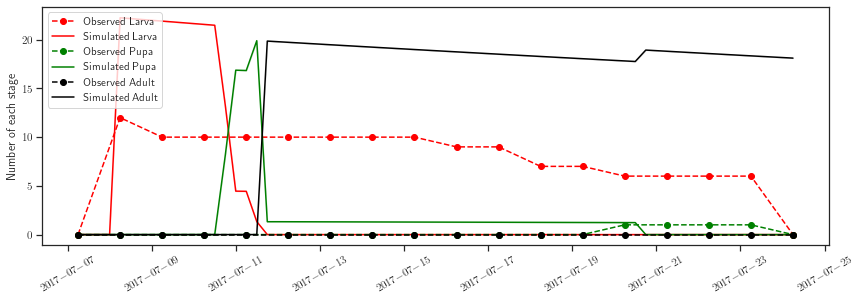

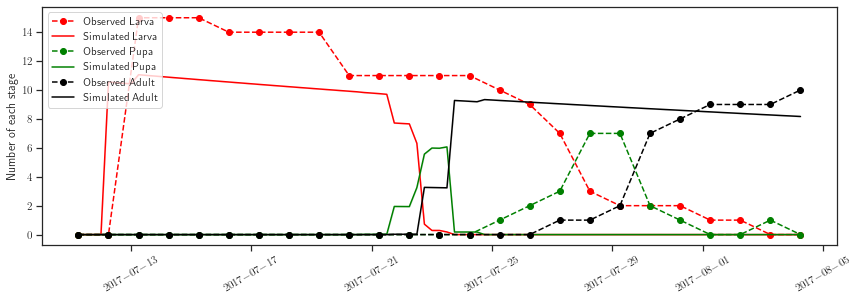

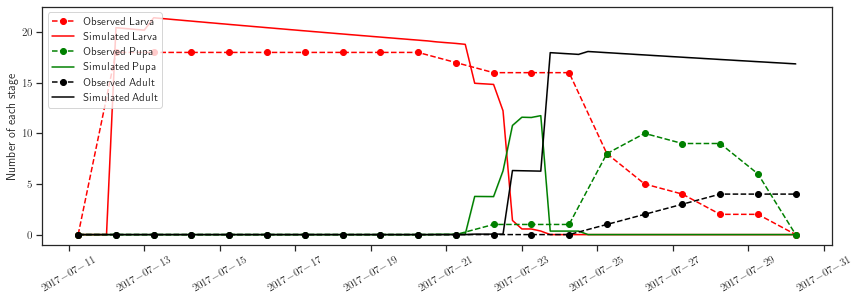

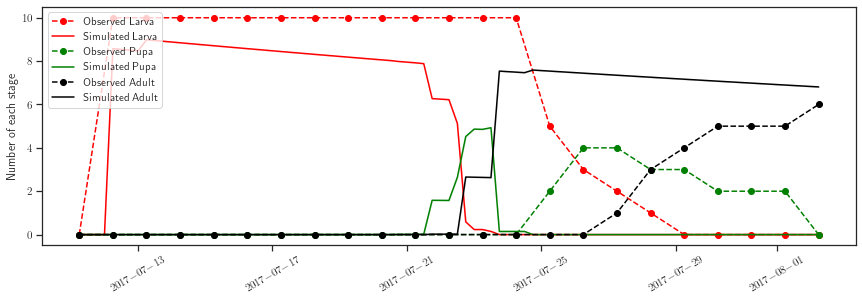

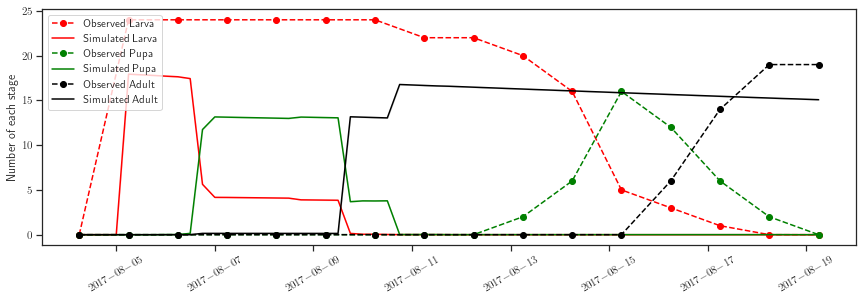

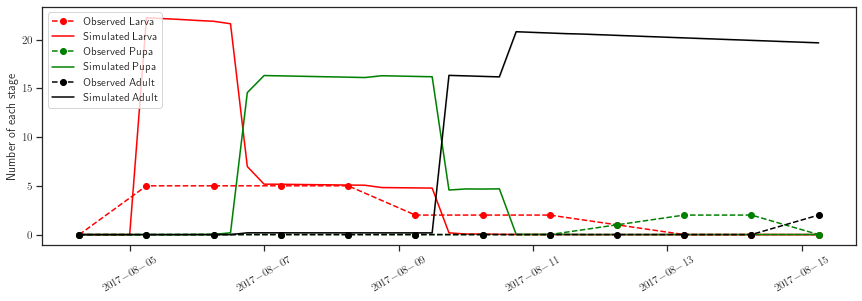

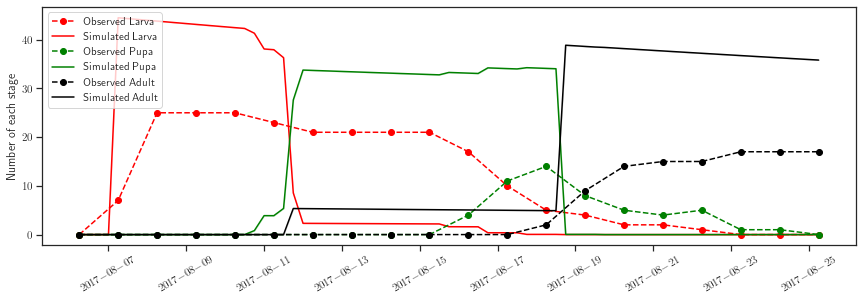

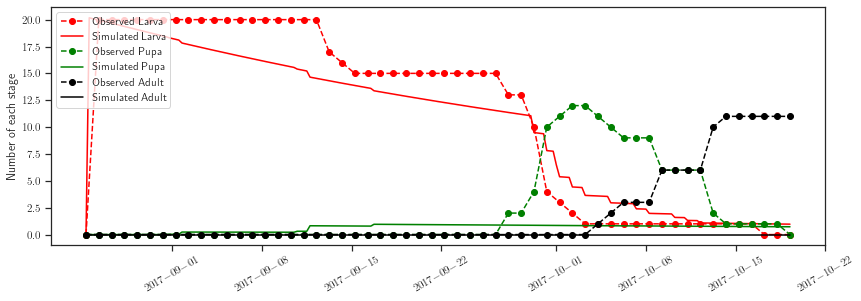

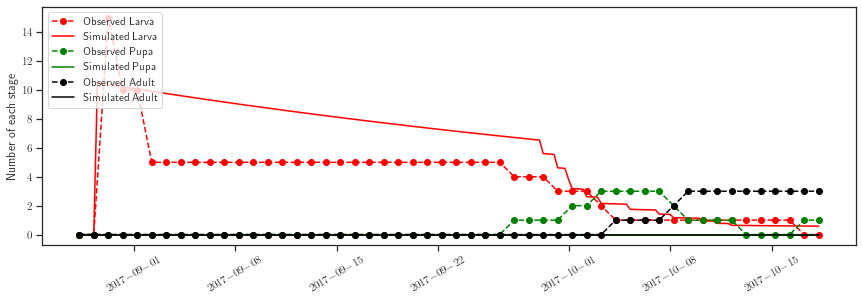

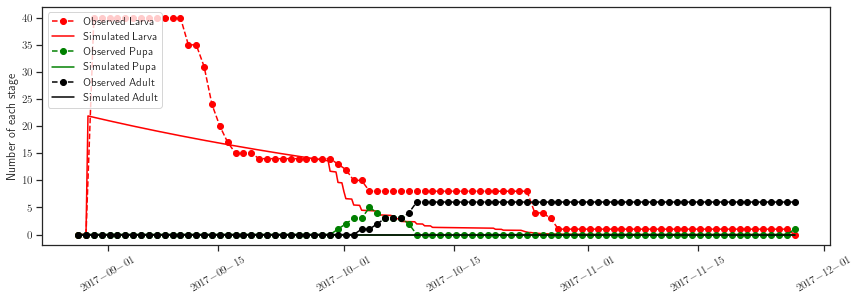

In [79]:
for g in range(len(testobs)):
    model.plotMatches([vtemp.obs[testobs[g]]],paramP,dates=True,legend=True,envir=False,filename="figures/test_Cxpip_E%d_O%d" %(g+1,testobs[g]),filetype="pdf")

# Figure S8

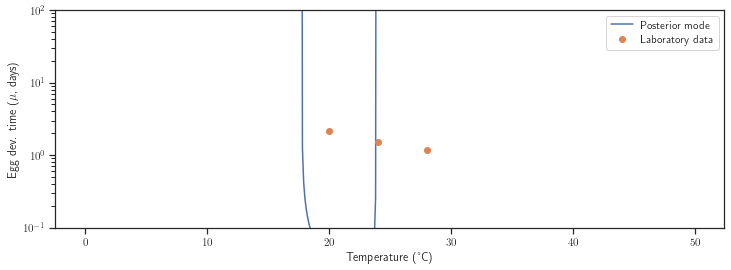

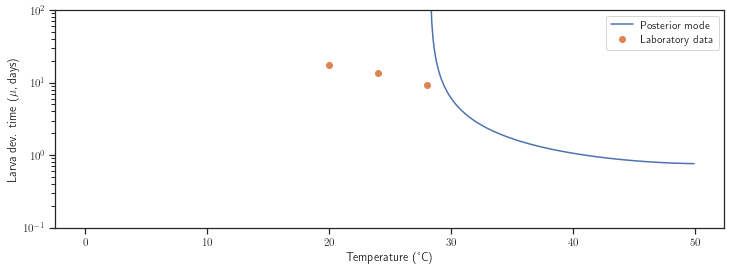

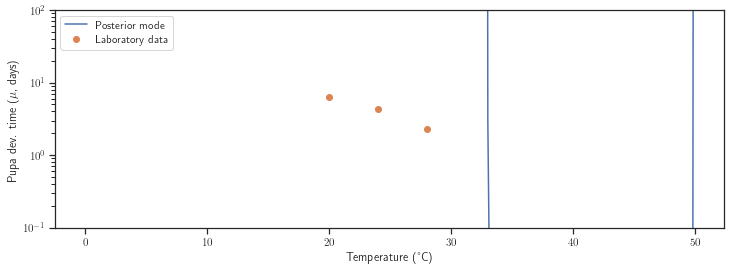

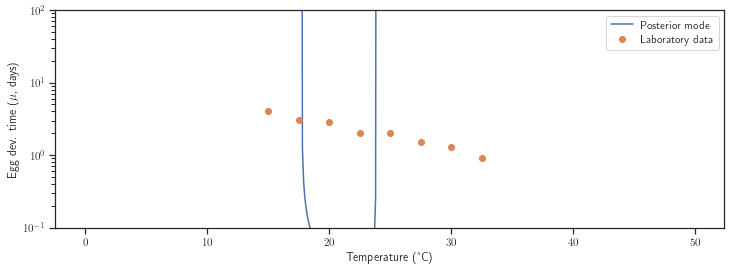

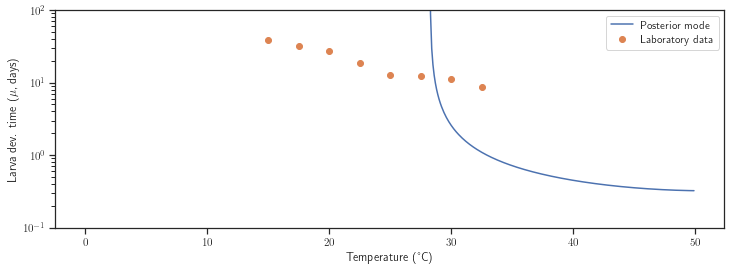

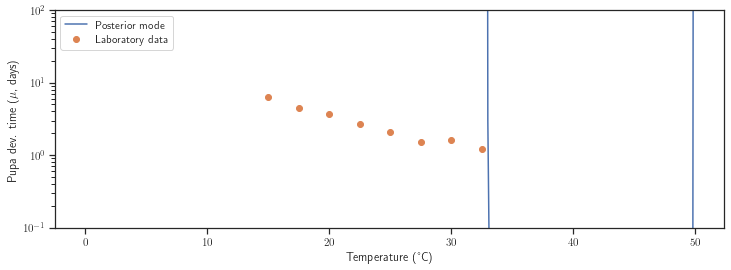

In [76]:
def plot(prs,par,ph,ylog=False):
    xr = numpy.arange(0,50,0.1)
    ph = numpy.repeat(ph,len(xr))
    #
    sims = numpy.array([model.getPD(xr,ph,model.rescalepar(pr)) for pr in prs]) # Yields daily values
    pp = numpy.percentile(sims,prange,axis=0)
    #
    plt.fill_between(xr,pp[0][:,par],pp[2][:,par],alpha=0.5)
    plt.plot(xr,pp[1][:,par], label="Posterior mode")
    if ylog:
        plt.yscale("log")
    else:
        plt.yscale("linear")
    plt.ylabel(model.parnames[par])
    plt.xlabel("Temperature (°C)")

plist = [
    [4,priorP.temp,13.0,priorP.d1m],
    [6,priorP.temp,13.0,priorP.d2m],
    [8,priorP.temp,13.0,priorP.d3m],
    [4,priorP.temp2,16.0,priorP.d1m2],
    [6,priorP.temp2,16.0,priorP.d2m2],
    [8,priorP.temp2,16.0,priorP.d3m2]
]
for i in range(len(plist)):
    p = plist[i]
    plot(paramP,p[0],p[2],ylog=True)
    plt.plot(p[1],p[3],'o',label="Laboratory data")
    plt.ylim(0.1,100)
    plt.legend()
    plt.savefig("figures/FigureS8_P%s.pdf" %i,bbox_inches="tight",dpi=300)
    plt.show()
    plt.close()

# Figure S9

In [18]:
dd = {i:modelsim.calcObs(vtemp.obs[i]) for i in testobs}
ret = numpy.array([modelsim.simObs(vtemp.obs_extend[k], paramP) for k in testobs])

In [31]:
paramP2 = paramP.copy()
paramP2[:,38] = 24.0
ret2 = numpy.array([modelsim.simObs(vtemp.obs_extend[k], paramP2) for k in testobs])

paramP3 = paramP.copy()
paramP3[:,38] = 0.0
ret3 = numpy.array([modelsim.simObs(vtemp.obs_extend[k], paramP3) for k in testobs])

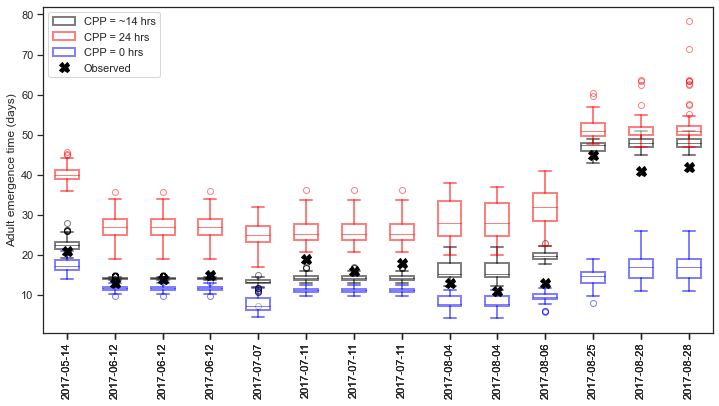

In [36]:
dd_lA = numpy.array([dd[testobs[i]]['lA'] for i in range(len(testobs))])
pp_lA = numpy.array([ret[i,:,3] for i in range(len(testobs))])
pp_lA2 = numpy.array([ret2[i,:,3] for i in range(len(testobs))])
pp_lA3 = numpy.array([ret3[i,:,3] for i in range(len(testobs))])
la = numpy.array([dd[testobs[i]]['Date'].date() for i in range(len(testobs))])

plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [12, 6]
fig, ax = plt.subplots()
c = "black"
bp1 = ax.boxplot(pp_lA.T,labels=la,patch_artist=True,
            boxprops=dict(facecolor="white", edgecolor=c, alpha=0.5, linewidth=2),
            capprops=dict(color=c,linewidth=2, alpha=0.5),
            whiskerprops=dict(color=c,linewidth=2, alpha=0.5),
            flierprops=dict(color=c, markeredgecolor=c, alpha=0.5),
            medianprops=dict(color=c, alpha=0.5))
c = "red"
bp2 = ax.boxplot(pp_lA2.T,labels=la,patch_artist=True,
            boxprops=dict(facecolor="white", edgecolor=c, alpha=0.5, linewidth=2),
            capprops=dict(color=c,linewidth=2, alpha=0.5),
            whiskerprops=dict(color=c,linewidth=2, alpha=0.5),
            flierprops=dict(color=c, markeredgecolor=c, alpha=0.5),
            medianprops=dict(color=c, alpha=0.5))
c = "blue"
bp3 = ax.boxplot(pp_lA3.T,labels=la,patch_artist=True,
            boxprops=dict(facecolor="white", edgecolor=c, alpha=0.5, linewidth=2),
            capprops=dict(color=c,linewidth=2, alpha=0.5),
            whiskerprops=dict(color=c,linewidth=2, alpha=0.5),
            flierprops=dict(color=c, markeredgecolor=c, alpha=0.5),
            medianprops=dict(color=c, alpha=0.5))
bp4 = ax.plot(numpy.arange(1,dd_lA.shape[0]+1),dd_lA.T,'X',c="black",markersize=10,label="Observed")
plt.xlim(2.5,dd_lA.shape[0]+0.5)
plt.ylabel("Adult emergence time (days)")
plt.xticks(rotation=90)
plt.legend([bp1['boxes'][0],bp2['boxes'][0],bp3['boxes'][0], bp4[0]],["CPP = ~14 hrs", "CPP = 24 hrs", "CPP = 0 hrs", "Observed"])
plt.savefig("figures/FigureS9.pdf",bbox_inches="tight",dpi=300)
plt.show()

# Table 1

In [23]:
for i in range(len(testobs)):
    pp_A = numpy.percentile(ret[i,:,1].astype(float),prange)
    pp_lA = numpy.percentile(ret[i,:,3].astype(float),prange)
    inside_A = (dd[testobs[i]]['A']>=pp_A[0]) and (dd[testobs[i]]['A']<=pp_A[2])
    inside_lA = (dd[testobs[i]]['lA']>=pp_lA[0]) and (dd[testobs[i]]['lA']<=pp_lA[2])
    diff_A = dd[testobs[i]]['A']-pp_A[1]
    diff_lA = dd[testobs[i]]['lA']-pp_lA[1]
    print("%s%s & %s & %.2f (%.2f-%.2f) & %.2f%s & %.2f & %.2f (%.2f-%.2f) & %.2f%s & %.2f\\\\" %(
        "E%d" %(i+1), 
        "*" if testobs[i] in trainobs else "",
        dd[testobs[i]]['Date'].date(), 
        pp_lA[1], pp_lA[0], pp_lA[2], dd[testobs[i]]['lA'], "*" if inside_lA else "", diff_lA,
        pp_A[1],   pp_A[0],  pp_A[2],  dd[testobs[i]]['A'],  "*" if inside_A else "", diff_A))

E1 & 2017-03-16 & nan (nan-nan) & nan & nan & 0.00 (0.00-0.00) & nan & nan\\
E2 & 2017-03-23 & nan (nan-nan) & nan & nan & 0.00 (0.00-0.00) & nan & nan\\
E3 & 2017-05-14 & 42.25 (42.25-42.25) & 21.00 & -21.25 & 5.36 (5.36-5.36) & 5.00 & -0.36\\
E4* & 2017-06-12 & 13.25 (13.25-13.25) & 13.00 & -0.25 & 19.05 (19.05-19.05) & 39.00 & 19.95\\
E5* & 2017-06-12 & 13.25 (13.25-13.25) & 14.00 & 0.75 & 12.08 (12.08-12.08) & 9.00 & -3.08\\
E6* & 2017-06-12 & 13.25 (13.25-13.25) & 15.00 & 1.75 & 20.91 (20.91-20.91) & 37.00 & 16.09\\
E7 & 2017-07-07 & 14.25 (14.25-14.25) & nan & nan & 18.24 (18.24-18.24) & nan & nan\\
E8 & 2017-07-11 & 10.25 (10.25-10.25) & 19.00 & 8.75 & 8.71 (8.71-8.71) & 10.00 & 1.29\\
E9 & 2017-07-11 & 10.25 (10.25-10.25) & 16.00 & 5.75 & 16.87 (16.87-16.87) & 4.00 & -12.87\\
E10 & 2017-07-11 & 10.25 (10.25-10.25) & 18.00 & 7.75 & 7.08 (7.08-7.08) & 6.00 & -1.08\\
E11 & 2017-08-04 & nan (nan-nan) & 13.00 & nan & 0.00 (0.00-0.00) & 19.00 & 19.00\\
E12 & 2017-08-04 & nan (nan-nan